News Classification

Безродный Владислав

In [ ]:
!pip install -q ktrain

     |████████████████████████████████| 25.3MB 18.7MB/s 
     |████████████████████████████████| 6.8MB 41.8MB/s 
     |████████████████████████████████| 983kB 41.3MB/s 
     |████████████████████████████████| 266kB 41.5MB/s 
     |████████████████████████████████| 1.9MB 33.1MB/s 
     |████████████████████████████████| 1.2MB 38.7MB/s 
     |████████████████████████████████| 471kB 40.3MB/s 
     |████████████████████████████████| 3.2MB 36.7MB/s 
     |████████████████████████████████| 890kB 39.4MB/s 


In [ ]:
import os
import math
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow_hub as hub
import tensorflow_datasets
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import pipeline, RobertaForMaskedLM, RobertaTokenizer
from sklearn.model_selection import train_test_split
import ktrain
from ktrain import text

print(tf.__version__)
print(ktrain.__version__)

%matplotlib inline
%config InlineBackend.figure_format='retina'

2.4.1
0.26.2


In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/news"
%cd /content/gdrive/My Drive/Kaggle/news

/content/gdrive/My Drive/Kaggle/news


In [ ]:
train_data = pd.read_csv("train.csv")
train_data.head()

,Id,title,text,images,source
0,1,Міністри Зеленського лишають мільйони пацієнті...,Понад півтора мільйони пацієнтів із тяжкими ді...,NaN,5
1,2,В АМКУ звертаються щодо незаконної державної д...,За 15 років державна підтримка виробництва ене...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png,6
2,5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили 15 698 нових хворих на корона...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png,2
3,9,Закриття міжбанку: гривня трохи ослабла,2 жовтня котирування гривні до долара на закри...,NaN,3
4,10,"У Москві помер український шахіст із бази ""Мир...",У п'ятницю низка російських ЗМІ повідомили про...,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233...",0


In [ ]:
train_data.shape

(16177, 5)

In [ ]:
classes = train_data.source.unique().tolist()
classes

[5, 6, 2, 3, 0, 4, 1]

In [ ]:
test_without_target_data = pd.read_csv("test_without_target.csv")
test_without_target_data.head()

,Id,title,text,images
0,0,Падіння економіки в Україні не є критичним - ЄБРР,Падіння економічного рівня в Україні не є крит...,NaN
1,3,Геймерам віддають безкоштовно шутер Rage 2 та ...,Шутер Rage 2 віддають безкоштовно в EGS / фото...,NaN
2,4,Записки из Луганска: привычка быть виноватыми ...,"""Ты печешь?"" – спрашивает у меня подруга, пере...","4530f95b-a014-424d-aefa-6f69fe82235a.png,2b8bc..."
3,6,Індекс Dow Jones вперше перевищив 30 тисяч пун...,На тлі новин щодо передачі влади у США та вакц...,NaN
4,7,Трамп і Меркель обговорили підтримку економічн...,Президент США Дональд Трамп і канцлерка Німечч...,NaN


In [ ]:
test_without_target_data.shape

(16183, 4)

In [ ]:
all_data = pd.concat([train_data.loc[:, 'Id':'images'], test_without_target_data])
all_data.head()

,Id,title,text,images
0,1,Міністри Зеленського лишають мільйони пацієнті...,Понад півтора мільйони пацієнтів із тяжкими ді...,NaN
1,2,В АМКУ звертаються щодо незаконної державної д...,За 15 років державна підтримка виробництва ене...,fd92a3dd-1109-49d8-8f5f-eeed72da22ef.png
2,5,У Польщі виявили майже 16 тисяч нових хворих н...,У Польщі виявили 15 698 нових хворих на корона...,f4a284d0-9bb7-4910-8a62-a7bfd0ec29b6.png
3,9,Закриття міжбанку: гривня трохи ослабла,2 жовтня котирування гривні до долара на закри...,NaN
4,10,"У Москві помер український шахіст із бази ""Мир...",У п'ятницю низка російських ЗМІ повідомили про...,"2cbb2339-6dd2-4000-a53c-225ec7aad892.png,d5233..."


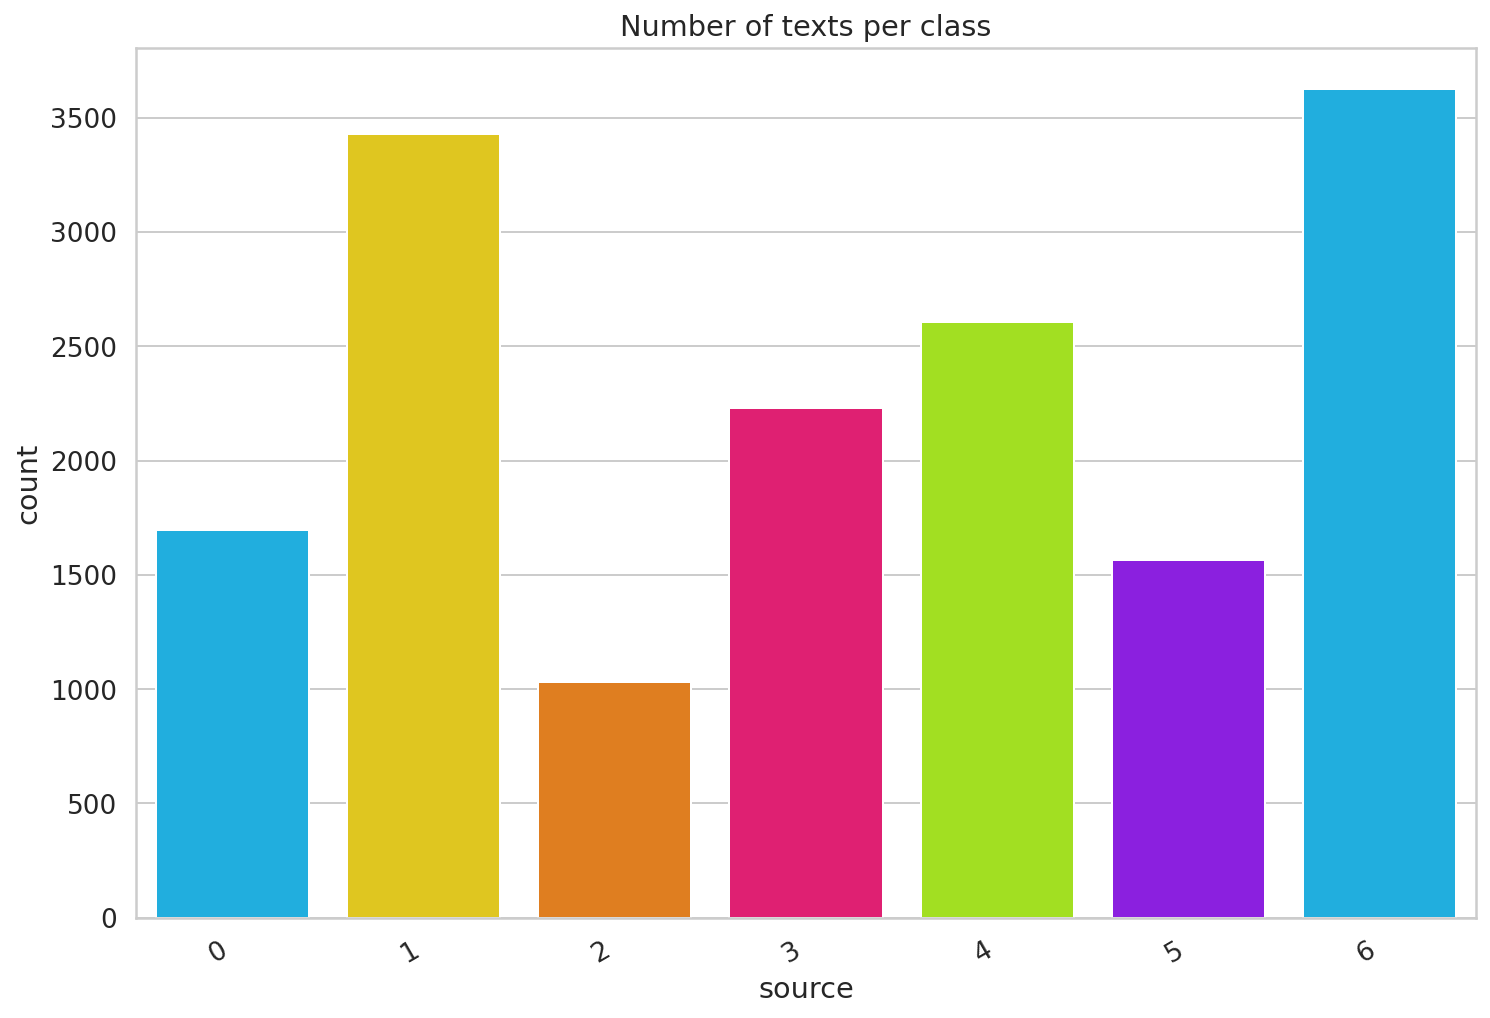

In [ ]:
chart = sns.countplot(train_data.source, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

## Title

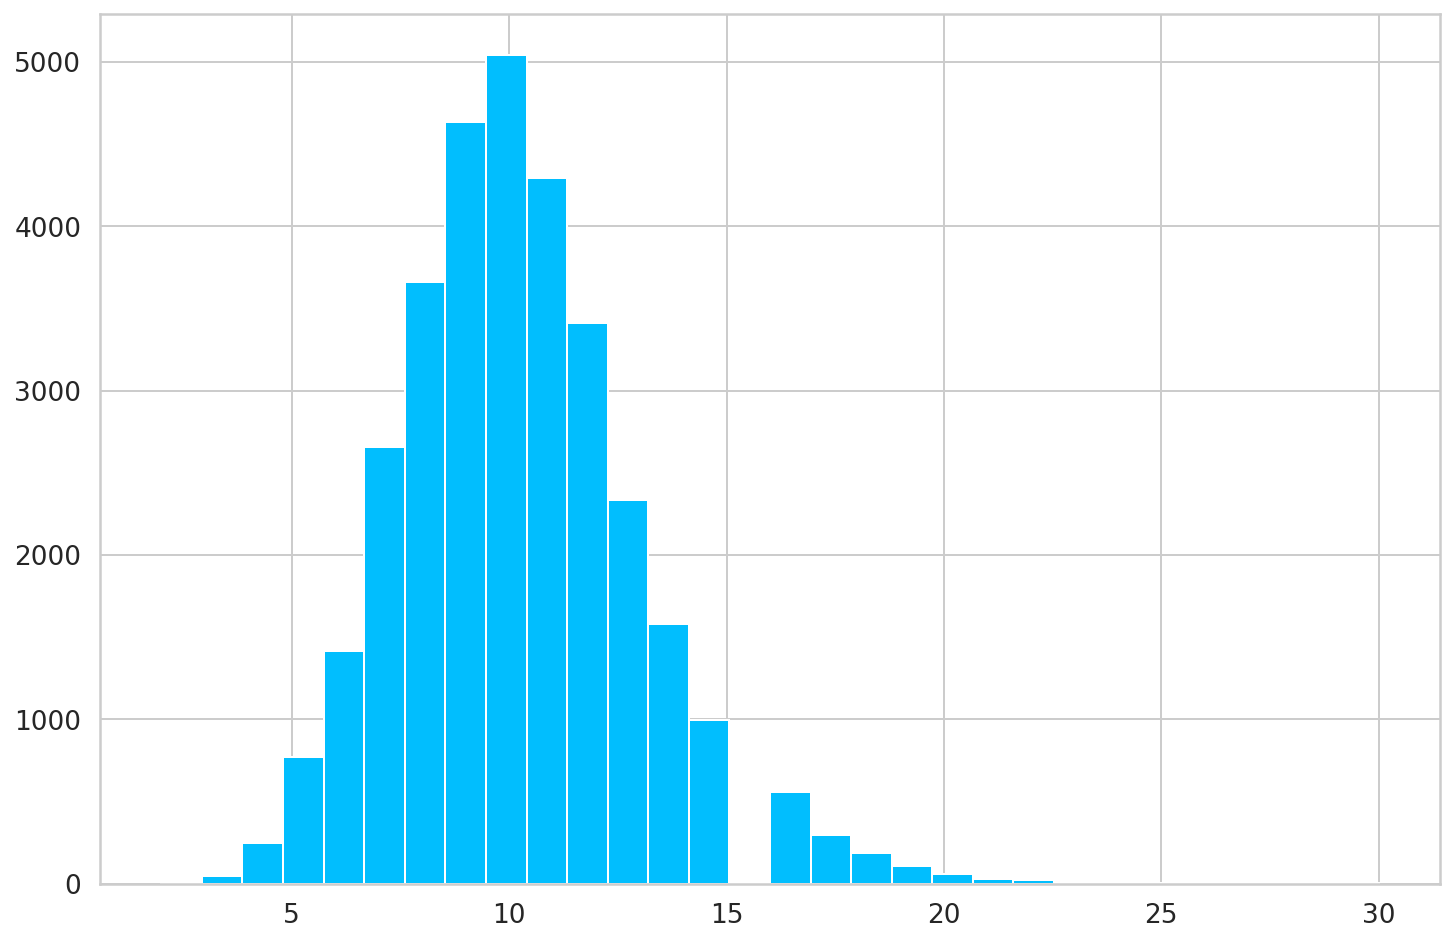

In [ ]:
seq_len = [len(i.split()) for i in all_data['title']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_title_len = np.max([len(i.split()) for i in all_data['title']])
max_title_len

30

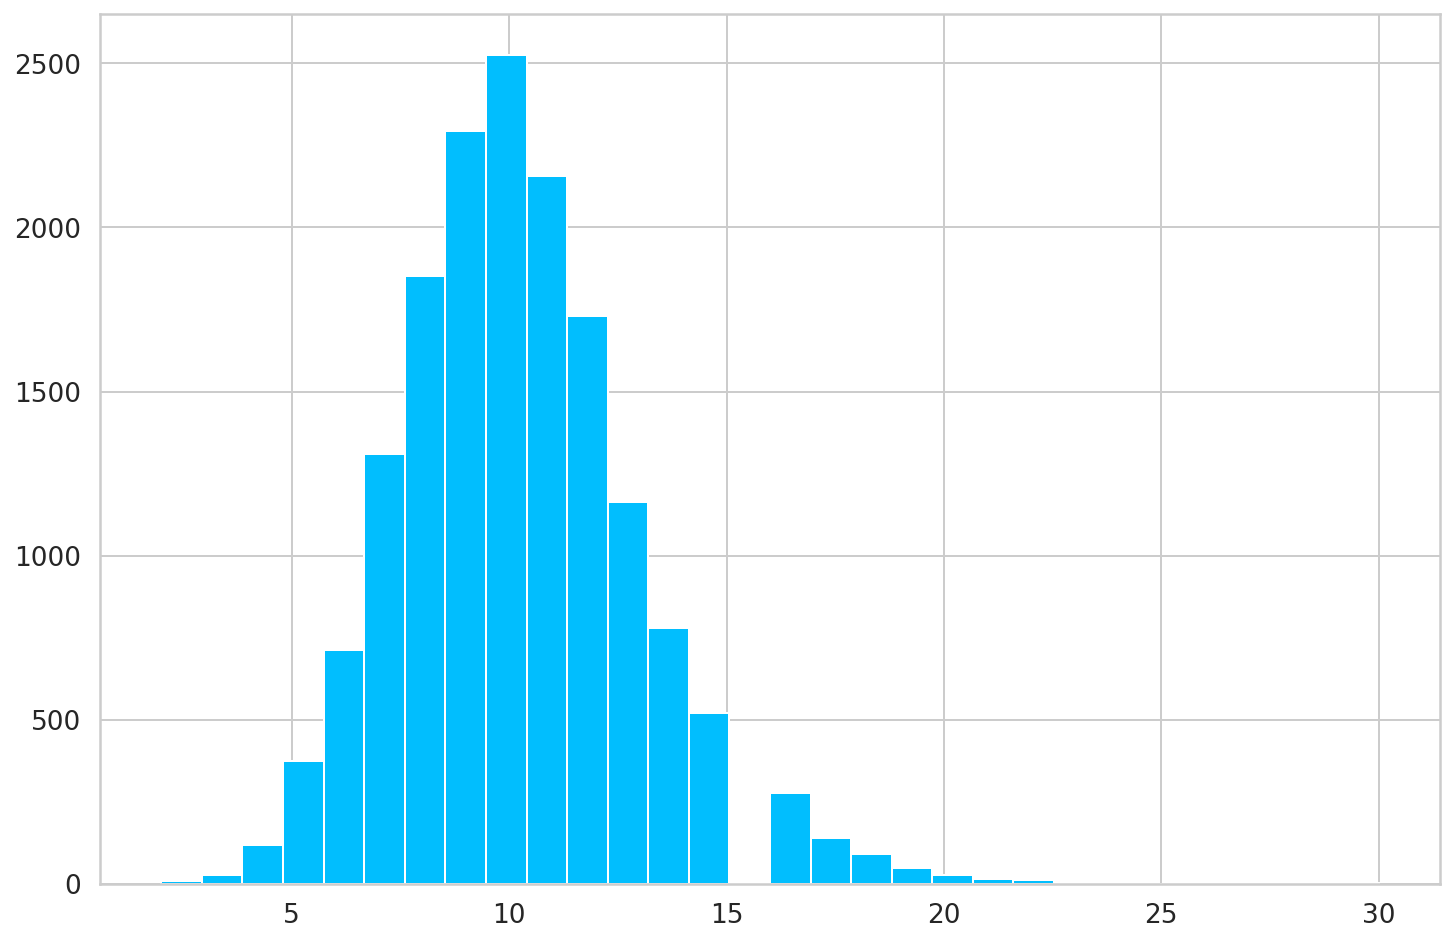

In [ ]:
seq_len = [len(i.split()) for i in train_data['title']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
np.max([len(i.split()) for i in train_data['title']])

30

In [ ]:
train_title, test_title, train_title_labels, test_title_labels = train_test_split(train_data['text'], train_data['source'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=train_data['source'])

In [ ]:
train_title.shape, test_title.shape, train_title_labels.shape, test_title_labels.shape 

((11323,), (4854,), (11323,), (4854,))

## Body

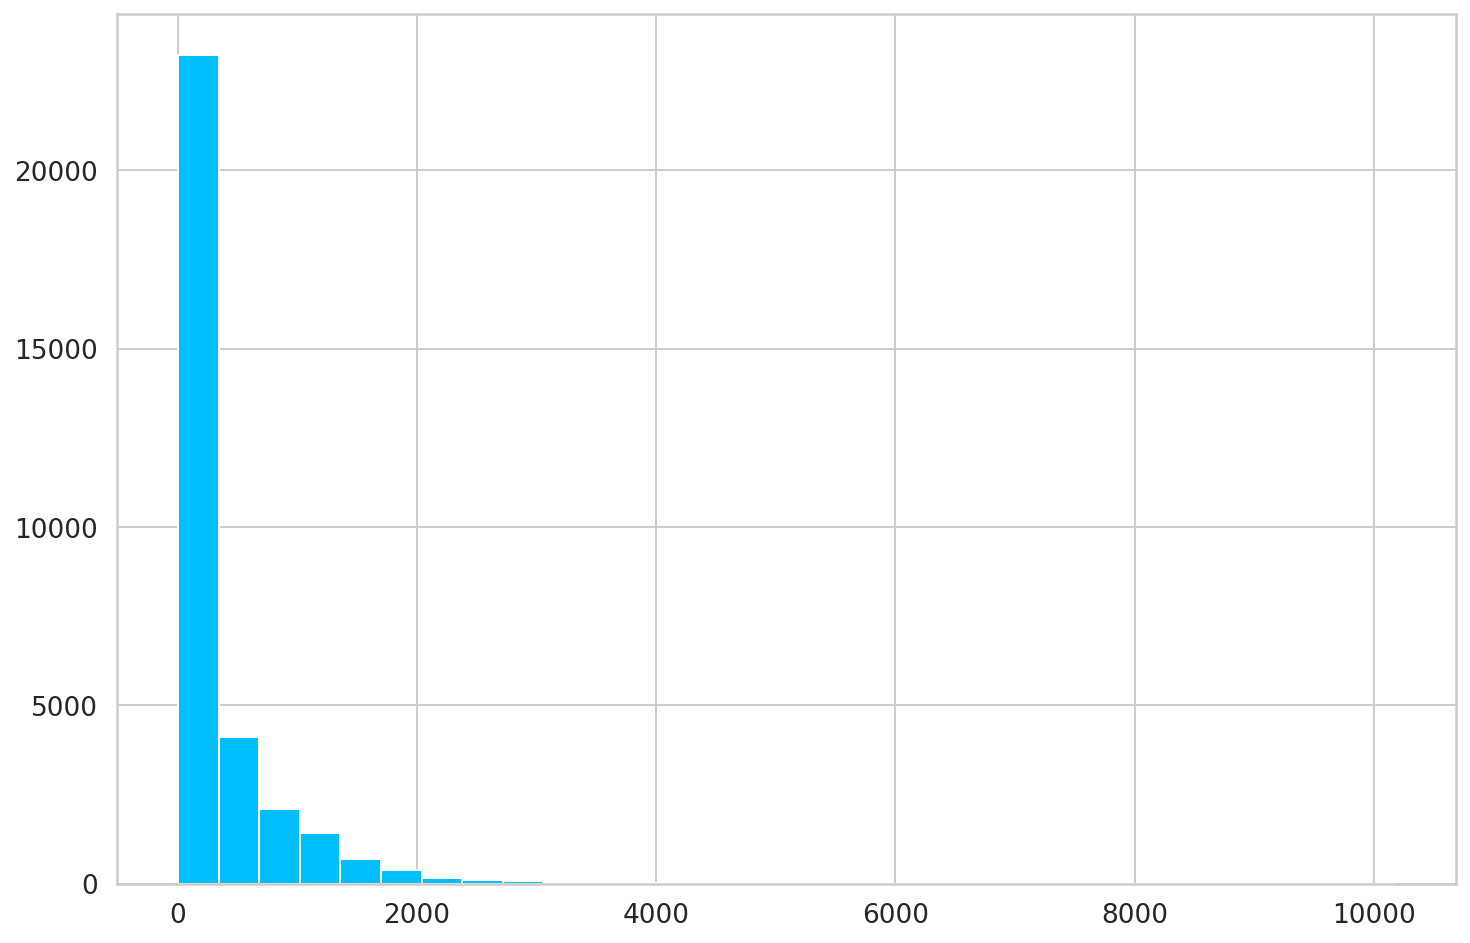

In [ ]:
seq_len = [len(i.split()) for i in all_data['text']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_body_len = np.max([len(i.split()) for i in all_data['text']])
max_body_len

10179

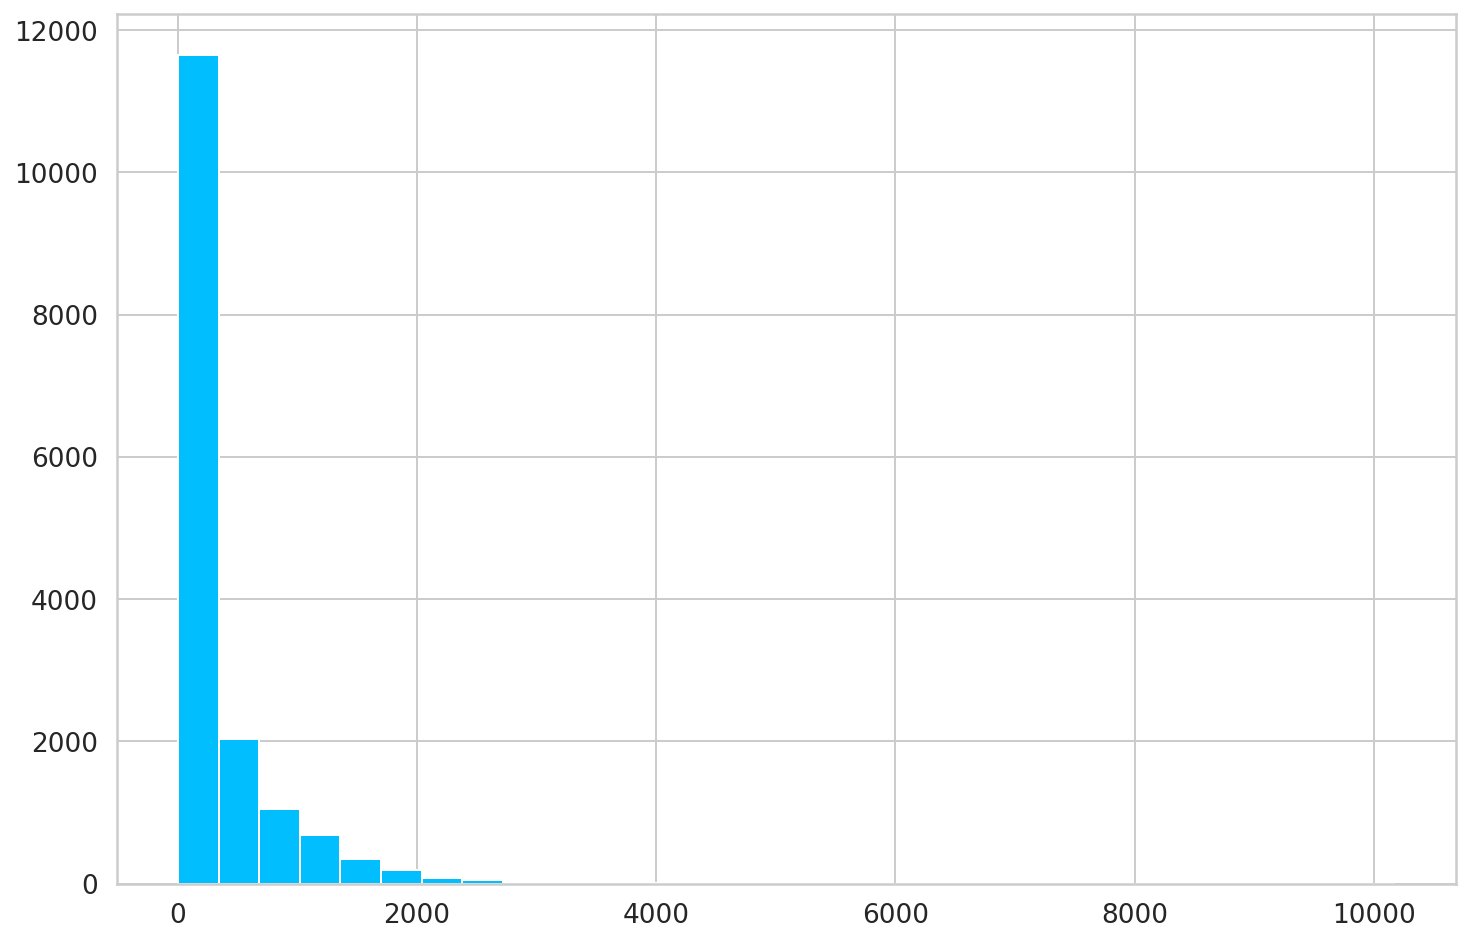

In [ ]:
seq_len = [len(i.split()) for i in train_data['text']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
np.max([len(i.split()) for i in train_data['text']])

10179

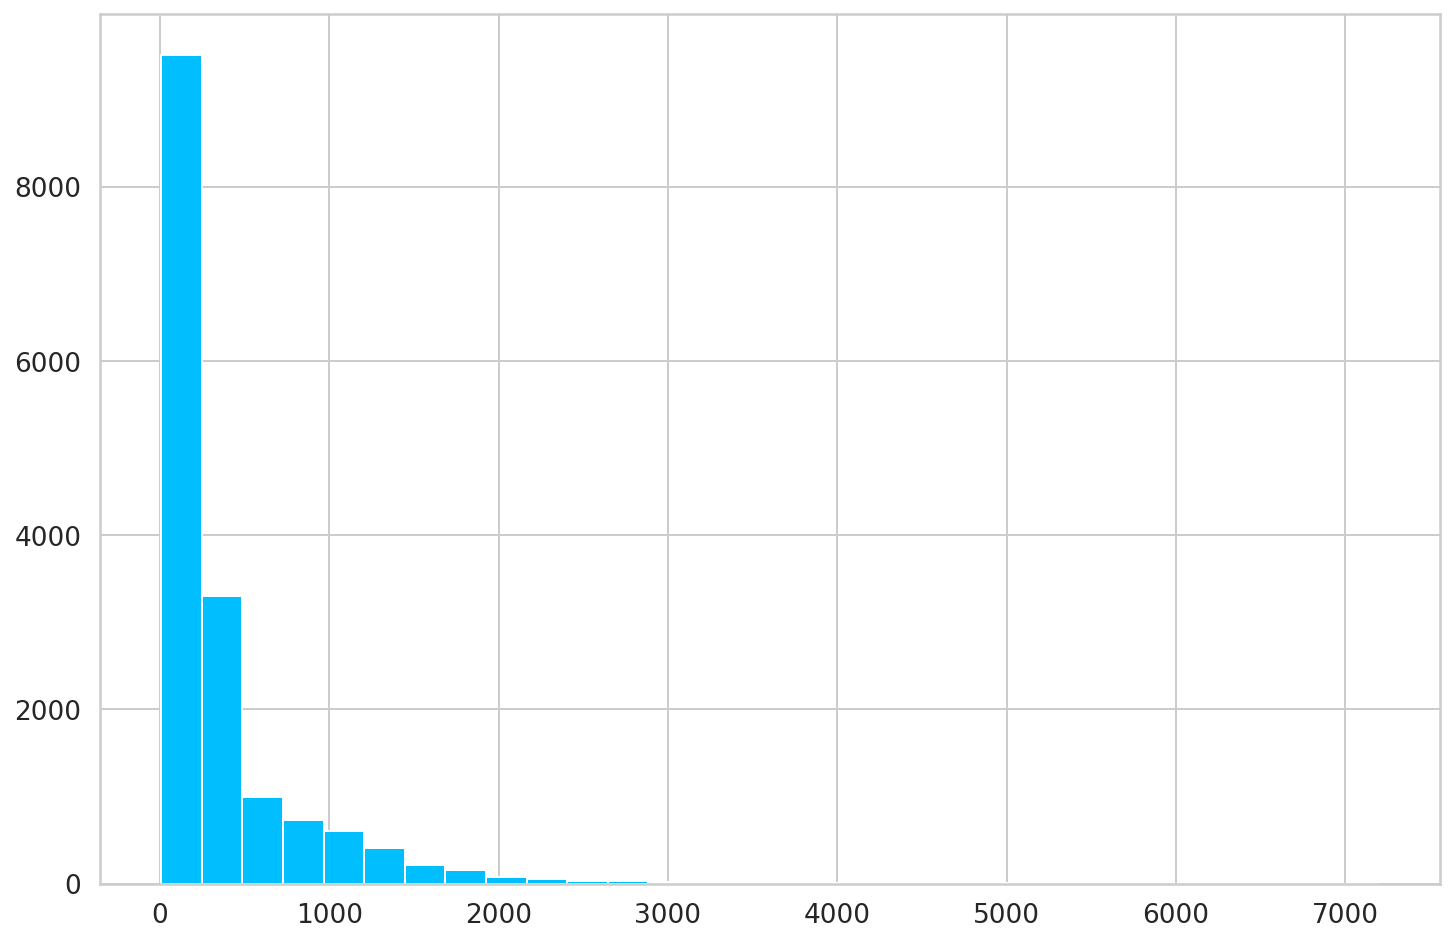

In [ ]:
seq_len = [len(i.split()) for i in test_without_target_data['text']]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
train_body, test_body, train_body_labels, test_body_labels = train_test_split(train_data['text'],
                                                                              train_data['source'],
                                                                              test_size=0.25,
                                                                              random_state=123)

In [ ]:
train_body.shape, test_body.shape, train_body_labels.shape, test_body_labels.shape 

((12132,), (4045,), (12132,), (4045,))

# ROBERTA

## Preprocessing for ROBERT

In [ ]:
MODEL_NAME = 'youscan/ukr-roberta-base'

In [ ]:
text_transformer = text.Transformer(MODEL_NAME, maxlen=500, classes=classes)
transformed_train_data = text_transformer.preprocess_train(np.array(train_body), np.array(train_body_labels))
transformed_validation_data = text_transformer.preprocess_test(np.array(test_body), np.array(test_body_labels))

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: uk
train sequence lengths:
	mean : 385
	95percentile : 1327
	99percentile : 2257


Is Multi-Label? False
preprocessing test...
language: uk
test sequence lengths:
	mean : 388
	95percentile : 1292
	99percentile : 2204


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
body_model = text_transformer.get_classifier(metrics=[f1_m])
learner = ktrain.get_learner(body_model, 
                             train_data=transformed_train_data, 
                             val_data=transformed_validation_data, 
                             batch_size=6)

404 Client Error: Not Found for url: https://huggingface.co/youscan/ukr-roberta-base/resolve/main/tf_model.h5


## Body Prediction

### Training for Body

In [ ]:
learner.fit_onecycle(5e-5, 3)

### Evaluation

In [ ]:
learner.validate(class_names=text_transformer.get_classes())

In [ ]:
learner.view_top_losses(n=1, preproc=t)

### Prediction

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=text_transformer)

In [ ]:
predictor.save('/body_model')

In [ ]:
predicted = predictor.predict(np.array(test_without_target_data['text']))
predicted

In [ ]:
subm = test_without_target_data.copy()
subm = subm.loc[:, ["Id"]]
subm["Predicted"] = predicted
subm.to_csv("result.csv", index=False)